<div style="border:solid Blue 2px; padding: 40px">
<h1> Определение возраста покупателей</h1>
    
    
Сетевой супермаркет планирует внедрение системы компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.
    
Задача построить модель, которая по фотографии определит приблизительный возраст человека. В базе данных набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


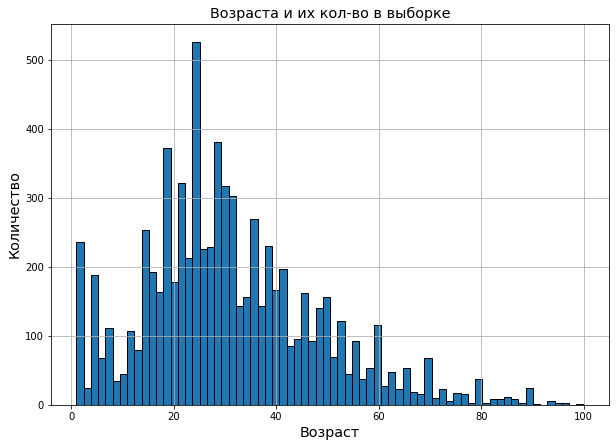

In [5]:
plt.figure(figsize=(10,7))
labels['real_age'].plot.hist(bins=70, grid=True, edgecolor='black')
plt.title('Возраста и их кол-во в выборке', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

<div style="border:solid Blue 2px; padding: 40px">

    Ревью:
- Открыли данные: типы корректные, пропусков нет
- Построили график распределения возрастов в выборке 
- В целом распределение адекватное, хоть и не совсем равномерное, что может немного осложнить задачу

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


<div style="border:solid Blue 2px; padding: 40px">
    Напечатаем несколько фотографий и посмотрим как они выглядят

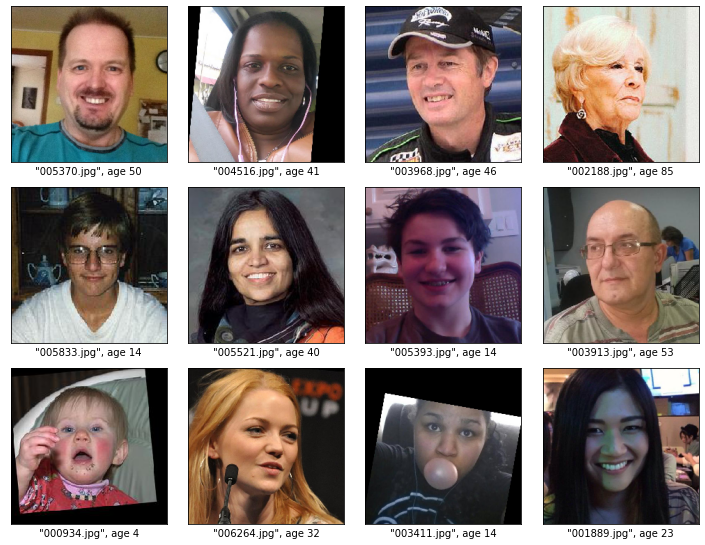

In [8]:
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(train_gen_flow[0][0][i]) # i-тая картинка первого батча
    plt.xlabel(f'"{train_gen_flow.filenames[train_gen_flow.index_array[i]]}", age {train_gen_flow[0][1][i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div style="border:solid Blue 2px; padding: 40px">
<h5> Вывод</h5>

- В датасете 7591 фотографии, это небольшая выборка, с учетом того что эти фотографии не идеальные.
- Видно что некоторые из фотографий смещены, обрезаны или повернуты - это осложняет задачу, но в реальности у нас не будет идеальных фотографий.
- В датасете превалируют фотографии где возраст людей варьируется от 18 до 40 лет.

## Обучение модели

#Обучено на тренажере GPU

```python

import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(
      model,
      train_datagen_flow,
      test_data_flow,
      batch_size=None,
      epochs=5,
      steps_per_epoch=None,
      validation_steps=None
    ):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps is None:
        validation_steps = len(test_data_flow)

    model.fit_generator(
      train_datagen_flow,
      validation_data=test_data_flow,
      epochs=epochs,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      verbose=2,
      shuffle=True
  )

    return model

```

```

Epoch 1/5
2023-07-04 13:08:14.105921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-04 13:08:16.031515: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 67s - loss: 198.8239 - mae: 10.3123 - val_loss: 761.4359 - val_mae: 22.6371
Epoch 2/5
356/356 - 38s - loss: 68.2361 - mae: 6.2807 - val_loss: 175.7173 - val_mae: 10.0038
Epoch 3/5
356/356 - 38s - loss: 36.9522 - mae: 4.7092 - val_loss: 77.1446 - val_mae: 6.5943
Epoch 4/5
356/356 - 38s - loss: 25.0164 - mae: 3.8407 - val_loss: 77.0753 - val_mae: 6.5470
Epoch 5/5
356/356 - 38s - loss: 18.2474 - mae: 3.2855 - val_loss: 76.9420 - val_mae: 6.5723
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 76.9420 - mae: 6.5723
Test MAE: 6.5723


```

## Анализ обученной модели

<div style="border:solid Blue 2px; padding: 40px">
<h3> Итоговый комментарий</h3>
    
    
- Данная модель построена с использованием архитектуры ResNet50, предобученной на ImageDataGenerator, оптимизированая алгоритмом Adam. Этот алгоритм универсален и работает довольно быстро.
- Цель обучения данной модели была довести метрику до менее 7, с даннной моделью МАЕ 6.5
- Модель можно рекоммендовать для бизнеса - Но стоит отметить что при продаже алкоголя эта модель может оказаться бесполезной для лиц детского и юношеского возраста поскольку предсказание в среднем идет с ошибкой до 7 лет. 
    - Стоит отдельно обратить внимание на улучшение модели для младшей возрастной категории - путем увеличения и корректировки самого датасета
    - возможно добавление новых слоев
    - поробовать другие методы аугментации данных, например рассмотреть библиотеку albumentations